In [1]:
# import the necessary packages
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2

Using TensorFlow backend.


In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Flatten())
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [0]:
class NeuralNetwork:
	def __init__(self, layers, alpha=0.1):
		# initialize the list of weights matrices, then store the
		# network architecture and learning rate
		self.W = []
		self.layers = layers
		self.alpha = alpha

		# start looping from the index of the first layer but
		# stop before we reach the last two layers
		for i in np.arange(0, len(layers) - 2):
			# randomly initialize a weight matrix connecting the
			# number of nodes in each respective layer together,
			# adding an extra node for the bias
			w = np.random.randn(layers[i] + 1, layers[i + 1] + 1)
			self.W.append(w / np.sqrt(layers[i]))

		# the last two layers are a special case where the input
		# connections need a bias term but the output does not
		w = np.random.randn(layers[-2] + 1, layers[-1])
		self.W.append(w / np.sqrt(layers[-2]))

	def __repr__(self):
		# construct and return a string that represents the network
		# architecture
		return "NeuralNetwork: {}".format(
			"-".join(str(l) for l in self.layers))

	def sigmoid(self, x):
		# compute and return the sigmoid activation value for a
		# given input value
		return 1.0 / (1 + np.exp(-x))

	def sigmoid_deriv(self, x):
		# compute the derivative of the sigmoid function ASSUMING
		# that `x` has already been passed through the `sigmoid`
		# function
		return x * (1 - x)

	def fit(self, X, y, epochs=1000, displayUpdate=100):
		# insert a column of 1's as the last entry in the feature
		# matrix -- this little trick allows us to treat the bias
		# as a trainable parameter within the weight matrix
		X = np.c_[X, np.ones((X.shape[0]))]

		# loop over the desired number of epochs
		for epoch in np.arange(0, epochs):
			# loop over each individual data point and train
			# our network on it
			for (x, target) in zip(X, y):
				self.fit_partial(x, target)

			# check to see if we should display a training update
			if epoch == 0 or (epoch + 1) % displayUpdate == 0:
				loss = self.calculate_loss(X, y)
				print("[INFO] epoch={}, loss={:.7f}".format(
					epoch + 1, loss))

	def fit_partial(self, x, y):
		# construct our list of output activations for each layer
		# as our data point flows through the network; the first
		# activation is a special case -- it's just the input
		# feature vector itself
		A = [np.atleast_2d(x)]

		# FEEDFORWARD:
		# loop over the layers in the network
		for layer in np.arange(0, len(self.W)):
			# feedforward the activation at the current layer by
			# taking the dot product between the activation and
			# the weight matrix -- this is called the "net input"
			# to the current layer
			net = A[layer].dot(self.W[layer])

			# computing the "net output" is simply applying our
			# non-linear activation function to the net input
			out = self.sigmoid(net)

			# once we have the net output, add it to our list of
			# activations
			A.append(out)

		# BACKPROPAGATION
		# the first phase of backpropagation is to compute the
		# difference between our *prediction* (the final output
		# activation in the activations list) and the true target
		# value
		error = A[-1] - y

		# from here, we need to apply the chain rule and build our
		# list of deltas `D`; the first entry in the deltas is
		# simply the error of the output layer times the derivative
		# of our activation function for the output value
		D = [error * self.sigmoid_deriv(A[-1])]

		# once you understand the chain rule it becomes super easy
		# to implement with a `for` loop -- simply loop over the
		# layers in reverse order (ignoring the last two since we
		# already have taken them into account)
		for layer in np.arange(len(A) - 2, 0, -1):
			# the delta for the current layer is equal to the delta
			# of the *previous layer* dotted with the weight matrix
			# of the current layer, followed by multiplying the delta
			# by the derivative of the non-linear activation function
			# for the activations of the current layer
			delta = D[-1].dot(self.W[layer].T)
			delta = delta * self.sigmoid_deriv(A[layer])
			D.append(delta)

		# since we looped over our layers in reverse order we need to
		# reverse the deltas
		D = D[::-1]

		# WEIGHT UPDATE PHASE
		# loop over the layers
		for layer in np.arange(0, len(self.W)):
			# update our weights by taking the dot product of the layer
			# activations with their respective deltas, then multiplying
			# this value by some small learning rate and adding to our
			# weight matrix -- this is where the actual "learning" takes
			# place
			self.W[layer] += -self.alpha * A[layer].T.dot(D[layer])

	def predict(self, X, addBias=True):
		# initialize the output prediction as the input features -- this
		# value will be (forward) propagated through the network to
		# obtain the final prediction
		p = np.atleast_2d(X)

		# check to see if the bias column should be added
		if addBias:
			# insert a column of 1's as the last entry in the feature
			# matrix (bias)
			p = np.c_[p, np.ones((p.shape[0]))]

		# loop over our layers in the network
		for layer in np.arange(0, len(self.W)):
			# computing the output prediction is as simple as taking
			# the dot product between the current activation value `p`
			# and the weight matrix associated with the current layer,
			# then passing this value through a non-linear activation
			# function
			p = self.sigmoid(np.dot(p, self.W[layer]))

		# return the predicted value
		return p

	def calculate_loss(self, X, targets):
		# make predictions for the input data points then compute
		# the loss
		targets = np.atleast_2d(targets)
		predictions = self.predict(X, addBias=False)
		loss = 0.5 * np.sum((predictions - targets) ** 2)

		# return the loss
		return loss

In [0]:
class Perceptron:
	def __init__(self, N, alpha=0.1):
		# initialize the weight matrix and store the learning rate
		self.W = np.random.randn(N + 1) / np.sqrt(N)
		self.alpha = alpha

	def step(self, x):
		# apply the step function
		return 1 if x > 0 else 0

	def fit(self, X, y, epochs=10):
		# insert a column of 1's as the last entry in the feature
		# matrix -- this little trick allows us to treat the bias
		# as a trainable parameter within the weight matrix
		X = np.c_[X, np.ones((X.shape[0]))]

		# loop over the desired number of epochs
		for epoch in np.arange(0, epochs):
			# loop over each individual data point
			for (x, target) in zip(X, y):
				# take the dot product between the input features
				# and the weight matrix, then pass this value
				# through the step function to obtain the prediction
				p = self.step(np.dot(x, self.W))

				# only perform a weight update if our prediction
				# does not match the target
				if p != target:
					# determine the error
					error = p - target

					# update the weight matrix
					self.W += -self.alpha * error * x

	def predict(self, X, addBias=True):
		# ensure our input is a matrix
		X = np.atleast_2d(X)

		# check to see if the bias column should be added
		if addBias:
			# insert a column of 1's as the last entry in the feature
			# matrix (bias)
			X = np.c_[X, np.ones((X.shape[0]))]

		# take the dot product between the input features and the
		# weight matrix, then pass the value through the step
		# function
		return self.step(np.dot(X, self.W))

In [0]:
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [7]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 55MB download may take a minute)
print("[INFO] accessing MNIST...")
dataset = datasets.fetch_mldata("MNIST Original")
data = dataset.data



[INFO] accessing MNIST...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	data = data.reshape(data.shape[0], 1, 28, 28)
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	data = data.reshape(data.shape[0], 28, 28, 1)

In [0]:
# scale the input data to the range [0, 1] and perform a train/test
# split
(trainX, testX, trainY, testY) = train_test_split(data / 255.0,
	dataset.target.astype("int"), test_size=0.25, random_state=42)


In [0]:
# convert the labels from integers to vectors
le = LabelBinarizer()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [11]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=128, epochs=20, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Train on 52500 samples, validate on 17500 samples
Epoch 1/20
52500/52500 [==============================] - 130s 2ms/step - loss: 0.9551 - acc: 0.7375 - val_loss: 0.5945 - val_acc: 0.8087
Epoch 2/20
52500/52500 [==============================] - 128s 2ms/step - loss: 0.2742 - acc: 0.9182 - val_loss: 0.2836 - val_acc: 0.9034
Epoch 3/20
52500/52500 [==============================] - 129s 2ms/step - loss: 0.1974 - acc: 0.9410 - val_loss: 0.1825 - val_acc: 0.9461
Epoch 4/20
52500/52500 [==============================] - 128s 2ms/step - loss: 0.1520 - acc: 0.9554 - val_loss: 0.1928 - val_acc: 0.9390
Epoch 5/20
52500/52500 [==============================] - 129s 2ms/step - loss: 0.1252 - acc: 0.9630 - val_loss: 0.1141 - val_acc: 0.9673
Epoch 6/20
52500/52500 [==============================] - 130s 2ms/step - loss: 0.1071 - acc: 0.9689 - val_loss: 0.1065 - val_acc: 0.9674
Epoch 7/20
52500/52500 [=======================

In [13]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in le.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1677
           1       0.99      0.99      0.99      1935
           2       0.98      0.99      0.99      1767
           3       0.98      0.98      0.98      1766
           4       0.98      0.99      0.99      1691
           5       0.99      0.98      0.99      1653
           6       0.99      0.99      0.99      1754
           7       0.98      0.99      0.98      1846
           8       0.97      0.98      0.97      1702
           9       0.99      0.96      0.97      1709

   micro avg       0.98      0.98      0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500



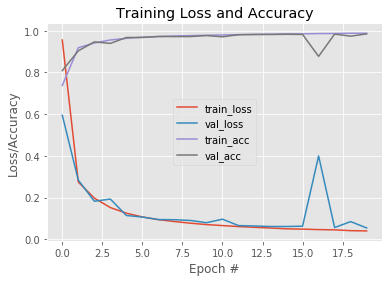

In [14]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()